In [2]:
import random
import scipy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pyplot import imread
import matplotlib
import numpy as np
import os
import imageio
import cv2
from random import seed
seed(42)

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier

import tensorflow
import keras
from keras import optimizers
from keras.models import Sequential, load_model, Model
from keras.callbacks import TensorBoard
from keras.activations import elu
from keras.initializers import he_normal
from keras.preprocessing import image
from keras.layers import Conv2D, Dense, Activation, Flatten, MaxPooling2D, Dropout, Input
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras import backend as K

from numpy.testing import assert_allclose

import nibabel as nib
from nibabel.testing import data_path

from PIL import Image

import nilearn
from nilearn import image, plotting

import ggplot
from ggplot import aes, geom_point, ggtitle

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for mo

# Functions

In [42]:
def get_subject(file_name): # parse out subjectids from file names
    return file_name[0:9]

In [43]:
def get_slice(): # read in all oasis1 data across discs
    
    path = '/Users/glynismattheisen/Desktop/Final/Discs'
    disc_list = os.listdir(path) # get list of discs from directory
    MacOS_file = '.DS_Store'
    if MacOS_file in disc_list:
        disc_list.remove(MacOS_file) # remove MacOS file

    brain_list, total_subjects = [], [] # generate list of brain images for input to NN, all subjects used in study
    
    for disc in disc_list:
        path_ind_disc = f'{path}/{disc}'
        subject_list_p_disc = os.listdir(path_ind_disc) # generate list of subjects in each disc
        if MacOS_file in subject_list_p_disc:
            subject_list_p_disc.remove(MacOS_file) # remove MacOS file
            
        for subj_id in subject_list_p_disc:
            total_subjects.append(subj_id) # maintain a list of all subjects included in study for diagnosis labeling later
    
            path_n4 = path_ind_disc + f'/{subj_id}/FSL_SEG/{subj_id}_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'
            path_n3 = path_ind_disc + f'/{subj_id}/FSL_SEG/{subj_id}_mpr_n3_anon_111_t88_masked_gfc_fseg_tra_90.gif'
            path_n6 = path_ind_disc + f'/{subj_id}/FSL_SEG/{subj_id}_mpr_n6_anon_111_t88_masked_gfc_fseg_tra_90.gif'
            path_n5 = path_ind_disc + f'/{subj_id}/FSL_SEG/{subj_id}_mpr_n5_anon_111_t88_masked_gfc_fseg_tra_90.gif'
            
            path_list = [path_n4,path_n3, path_n6,path_n5]
            for i in path_list:
                if os.path.exists(i) == True:
                    brain_list.append(plt.imread(i)) # append if file format exists

    return disc_list, brain_list, total_subjects

In [44]:
def get_diagnosis(total_subjects): # builds a dictionary of subjects and diagnoses
    oasis1 = pd.read_csv('/Users/glynismattheisen/Desktop/Final2/oasis_cross-sectional.csv') # read in summary file
    oasis1['CDR'].fillna(0, inplace=True) # null values are healthy diagnoses
    diagnosis_qual={0.:'normal', 0.5:'alz', 1.:'alz', 2.:'alz' } # convert to labels
    oasis1.replace({"CDR": diagnosis_qual}, inplace=True)
    diagnosis_quant={'normal':0,'alz':1} # convert back to numbers
    oasis1.replace({"CDR": diagnosis_quant}, inplace=True)
    
    subjects = []    # get subject names for each MRI ID
    for subj_id in total_subjects:
        subjects.append(get_subject(subj_id))
        
    subjects = pd.DataFrame(subjects, columns = ['Subject']) # convert to dataframe
    oasis1['Subject'] =oasis1['ID'].apply(get_subject)     # extract subject ID from MR ID
    
    diagnosis_dict= {}     # create a dictionary with subject and diagnosis
    for num in range(0,436):
        diagnosis_dict[oasis1['Subject'][num]] = oasis1['CDR'][num]
        
    diag = [] # create a list of diagnoses to append to dataframe of subjects
    for subj in subjects['Subject']:
        diag.append(diagnosis_dict[subj])

    subjects['Diagnosis'] = pd.DataFrame(diag)
    
    return subjects

In [45]:
def balance_set(subjects, total_subjects, disc_list): # make a list of 236 alz patients in order to even out the lists
    alz_subjects = subjects.sort_values(by='Diagnosis', ascending = False).head(97) # all subjects diagnosed as alz
    alz_subjects = alz_subjects.append(alz_subjects)
    head = alz_subjects.head(42)
    alz_subjects = alz_subjects.append(head)    
    
    for subj in alz_subjects['Subject']:
        total_subjects.append(str(subj) + '_MR1') # maintain a list of all subjects included in study for diagnosis labeling later
    for disc in disc_list:
            path = f'/Users/glynismattheisen/Desktop/Final/Discs/{disc}'

            for i in alz_subjects['Subject']:

                path_n4 = path + f'/{i}_MR1/FSL_SEG/{i}_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'
                path_n3 = path + f'/{i}_MR1/FSL_SEG/{i}_MR1_mpr_n3_anon_111_t88_masked_gfc_fseg_tra_90.gif'
                path_n6 = path + f'/{i}_MR1/FSL_SEG/{i}_MR1_mpr_n6_anon_111_t88_masked_gfc_fseg_tra_90.gif'
                path_n5 = path + f'/{i}_MR1/FSL_SEG/{i}_MR1_mpr_n5_anon_111_t88_masked_gfc_fseg_tra_90.gif'

                path_list = [path_n4,path_n3, path_n6,path_n5]
                for i in path_list:
                    if os.path.exists(i) == True:
                        brain_list.append(plt.imread(i)) # append if file format exists

    brain_array = np.asarray(brain_list)
    return brain_array, alz_subjects

In [459]:
disc_list, brain_list, total_subjects = get_slice()

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning:

unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc12/OAS1_0448_MR1/FSL_SEG/OAS1_0448_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'>

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning:

unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc12/OAS1_0449_MR1/FSL_SEG/OAS1_0449_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'>

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning:

unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc12/OAS1_0439_MR1/FSL_SEG/OAS1_0439_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'>

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning:

unclosed file <_io.BufferedReader name='/

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning:

unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc1/OAS1_0041_MR1/FSL_SEG/OAS1_0041_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'>

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning:

unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc1/OAS1_0042_MR1/FSL_SEG/OAS1_0042_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'>

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning:

unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc7/OAS1_0263_MR1/FSL_SEG/OAS1_0263_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'>

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning:

unclosed file <_io.BufferedReader name='/Use

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning:

unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc2/OAS1_0075_MR1/FSL_SEG/OAS1_0075_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'>

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning:

unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc2/OAS1_0061_MR1/FSL_SEG/OAS1_0061_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'>

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning:

unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc2/OAS1_0049_MR1/FSL_SEG/OAS1_0049_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'>

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning:

unclosed file <_io.BufferedReader name='/Use

In [460]:
subjects = get_diagnosis(total_subjects)

In [461]:
brain_array, alz_subjects = balance_set(subjects, total_subjects, disc_list)
subjects = get_diagnosis(total_subjects)

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning:

unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc12/OAS1_0440_MR1/FSL_SEG/OAS1_0440_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'>

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning:

unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc12/OAS1_0454_MR1/FSL_SEG/OAS1_0454_MR1_mpr_n3_anon_111_t88_masked_gfc_fseg_tra_90.gif'>

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning:

unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc12/OAS1_0441_MR1/FSL_SEG/OAS1_0441_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'>

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning:

unclosed file <_io.BufferedReader name='/

# Convoluted Neural Network

In [462]:
x = brain_array # array of image values
y = np.asarray(subjects['Diagnosis'])
x = x.reshape(-1, 208, 176,1)

norm = lambda x :(x - np.min(x)) / (np.max(x) - np.min(x)) # normalize x values
x_norm = norm(x)
assert (np.min(x_norm), np.max(x_norm)) == (0.0, 1.0)

X_im_train, X_im_test, y_im_train, y_im_test = train_test_split(x_norm,y, random_state = 42)

In [109]:
model = Sequential([
    Conv2D(filters=100,kernel_size=(3,3),strides=(10,10), input_shape=(208,176,1),padding ='same'),
    MaxPooling2D(pool_size=(2,2),padding='valid'),
    Activation('sigmoid'),
    Conv2D(filters=50,kernel_size=(3,3),strides=(5,5),padding ='same'),
    MaxPooling2D(pool_size=(2,2),padding='valid'),
    Activation('sigmoid'),
    Conv2D(filters=25,kernel_size=(3,3),strides=(1,1),padding ='same'),
    MaxPooling2D(pool_size=(1,1),padding='valid'),
    Activation('sigmoid'),
    Flatten(),
    Dense(1),
    Activation('sigmoid'),
])

In [110]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_im_train,y_im_train,epochs=100, batch_size=75)

Epoch 1/100
499/499 [==============================] - 1s 2ms/step - loss: 0.6963 - acc: 0.4850
Epoch 2/100
499/499 [==============================] - 0s 580us/step - loss: 0.6934 - acc: 0.5010
Epoch 3/100
499/499 [==============================] - 0s 602us/step - loss: 0.6938 - acc: 0.4709
Epoch 4/100
499/499 [==============================] - 0s 650us/step - loss: 0.6935 - acc: 0.5010
Epoch 5/100
499/499 [==============================] - 0s 617us/step - loss: 0.6941 - acc: 0.4669
Epoch 6/100
499/499 [==============================] - 0s 559us/step - loss: 0.6942 - acc: 0.4990
Epoch 7/100
499/499 [==============================] - 0s 630us/step - loss: 0.6931 - acc: 0.4850
Epoch 8/100
499/499 [==============================] - 0s 597us/step - loss: 0.6942 - acc: 0.5010
Epoch 9/100
499/499 [==============================] - 0s 600us/step - loss: 0.6945 - acc: 0.4790
Epoch 10/100
499/499 [==============================] - 0s 572us/step - loss: 0.6945 - acc: 0.4830
Epoch 11/100
499/499 

499/499 [==============================] - 0s 503us/step - loss: 0.4128 - acc: 0.8096
Epoch 84/100
499/499 [==============================] - 0s 487us/step - loss: 0.4104 - acc: 0.8156
Epoch 85/100
499/499 [==============================] - 0s 485us/step - loss: 0.4060 - acc: 0.8156
Epoch 86/100
499/499 [==============================] - 0s 490us/step - loss: 0.4072 - acc: 0.8196
Epoch 87/100
499/499 [==============================] - 0s 553us/step - loss: 0.4051 - acc: 0.8136
Epoch 88/100
499/499 [==============================] - 0s 507us/step - loss: 0.4061 - acc: 0.8257
Epoch 89/100
499/499 [==============================] - 0s 547us/step - loss: 0.4140 - acc: 0.8056
Epoch 90/100
499/499 [==============================] - 0s 516us/step - loss: 0.4040 - acc: 0.8176
Epoch 91/100
499/499 [==============================] - 0s 490us/step - loss: 0.4037 - acc: 0.8236
Epoch 92/100
499/499 [==============================] - 0s 484us/step - loss: 0.4087 - acc: 0.8236
Epoch 93/100
499/499 [=

In [148]:
def get_metrics(model, X_test, y_test):
    results = model.evaluate(X_test, y_test)
    accuracy = round(results[1]*100,2)
    
    Y_pred = model.predict_classes(X_test)
    
    recall = round((recall_score(y_test, Y_pred))*100, 2)
    precision = round(precision_score(y_test, Y_pred)*100, 2)
    
    return accuracy, recall, precision

In [149]:
model_accuracy, model_recall, model_precision = get_metrics(model,X_im_test, y_im_test)

167/167 [==============================] - 0s 302us/step


# Visualize the Input

                                  Test Images                                   


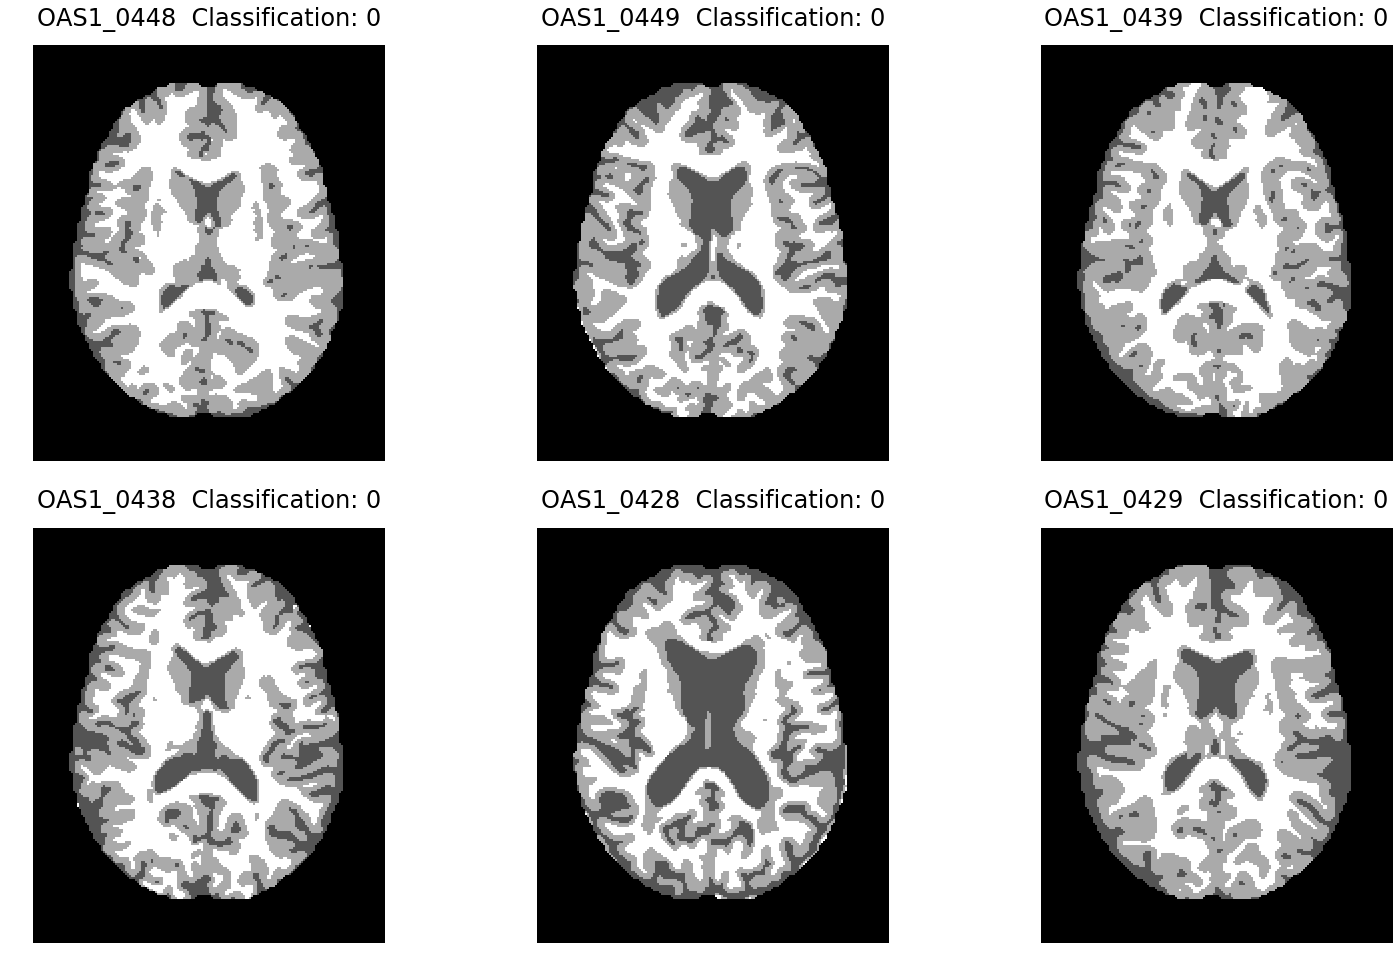

In [80]:
def plot_test_images(subject,diagnosis, array):
    plt.figure(figsize=(20, 20))
    print("Test Images".center(os.get_terminal_size().columns))
    for i in range(6):
        plt.subplot(3, 3, i+1)
        plt.title(str(subject[i]) +'  Classification: ' + str(diagnosis[i]), fontsize=24, pad = 20)
        plt.tight_layout()
        plt.axis('off')
        plt.imshow(array[i], cmap='gray')
        plt.subplots_adjust(wspace=0.25)
    plt.show()  
    
plot_test_images(subjects['Subject'],subjects['Diagnosis'],brain_array)

# T-SNE

In [463]:
x = x[:,:,:,0]
tsne = TSNE(n_components=2, init='pca', random_state=42)
assert x.shape == (666, 208, 176)
X_tsne = tsne.fit_transform(x.reshape((666,208*176)))

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning:

the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.



In [464]:
def run_tsne(X_tsne, y):
    X_t_train, X_t_test, y_t_train, y_t_test = train_test_split(X_tsne,y, random_state = 42)
    he = keras.initializers.he_normal(seed=42)    
    model_t = Sequential([
    Dense(60, input_shape=(2,), kernel_initializer=he),
    Activation('sigmoid'),
    Dense(30),
    Activation('sigmoid'),
    Dense(15),
    Activation('sigmoid'),
    Dense(1),
    Activation('sigmoid'),
    ])
    
    optimizer = keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model_t.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model_t, X_t_train, X_t_test, y_t_train, y_t_test, tsne

model_t, X_t_train, X_t_test, y_t_train, y_t_test, tsne= run_tsne(X_tsne,y)

# tboard = keras.callbacks.TensorBoard(log_dir='/Users/glynismattheisen/Desktop/Final',histogram_freq=5, write_graph=True, write_images=True)

In [135]:
model_t.fit(X_t_train,y_t_train,epochs=100, batch_size=50, validation_split=0.2)

Train on 399 samples, validate on 100 samples
Epoch 1/100
399/399 [==============================] - 1s 1ms/step - loss: 0.6338 - acc: 0.7544 - val_loss: 0.5064 - val_acc: 0.8500
Epoch 2/100
399/399 [==============================] - 0s 46us/step - loss: 0.5116 - acc: 0.8045 - val_loss: 0.3962 - val_acc: 0.8500
Epoch 3/100
399/399 [==============================] - 0s 30us/step - loss: 0.4730 - acc: 0.8070 - val_loss: 0.3779 - val_acc: 0.8500
Epoch 4/100
399/399 [==============================] - 0s 37us/step - loss: 0.4568 - acc: 0.8020 - val_loss: 0.3707 - val_acc: 0.8700
Epoch 5/100
399/399 [==============================] - 0s 85us/step - loss: 0.4416 - acc: 0.8095 - val_loss: 0.3558 - val_acc: 0.8700
Epoch 6/100
399/399 [==============================] - 0s 37us/step - loss: 0.4315 - acc: 0.8120 - val_loss: 0.3461 - val_acc: 0.8700
Epoch 7/100
399/399 [==============================] - 0s 37us/step - loss: 0.4251 - acc: 0.8221 - val_loss: 0.3434 - val_acc: 0.8700
Epoch 8/100
399/3

399/399 [==============================] - 0s 44us/step - loss: 0.3776 - acc: 0.8346 - val_loss: 0.3471 - val_acc: 0.8700
Epoch 62/100
399/399 [==============================] - 0s 34us/step - loss: 0.3752 - acc: 0.8396 - val_loss: 0.3530 - val_acc: 0.8500
Epoch 63/100
399/399 [==============================] - 0s 52us/step - loss: 0.3823 - acc: 0.8421 - val_loss: 0.3625 - val_acc: 0.8600
Epoch 64/100
399/399 [==============================] - 0s 37us/step - loss: 0.3781 - acc: 0.8321 - val_loss: 0.3483 - val_acc: 0.8600
Epoch 65/100
399/399 [==============================] - 0s 52us/step - loss: 0.3816 - acc: 0.8271 - val_loss: 0.3581 - val_acc: 0.8500
Epoch 66/100
399/399 [==============================] - 0s 40us/step - loss: 0.3771 - acc: 0.8321 - val_loss: 0.3675 - val_acc: 0.8600
Epoch 67/100
399/399 [==============================] - 0s 41us/step - loss: 0.3734 - acc: 0.8396 - val_loss: 0.3559 - val_acc: 0.8600
Epoch 68/100
399/399 [==============================] - 0s 55us/step

In [153]:
tsne_accuracy, tsne_recall, tsne_precision = get_metrics(model_t,X_t_test, y_t_test)

167/167 [==============================] - 0s 37us/step


In [154]:
prediction = model_t.predict_classes(X_t_test)

# Visualize the T-SNE

<Figure size 432x288 with 0 Axes>

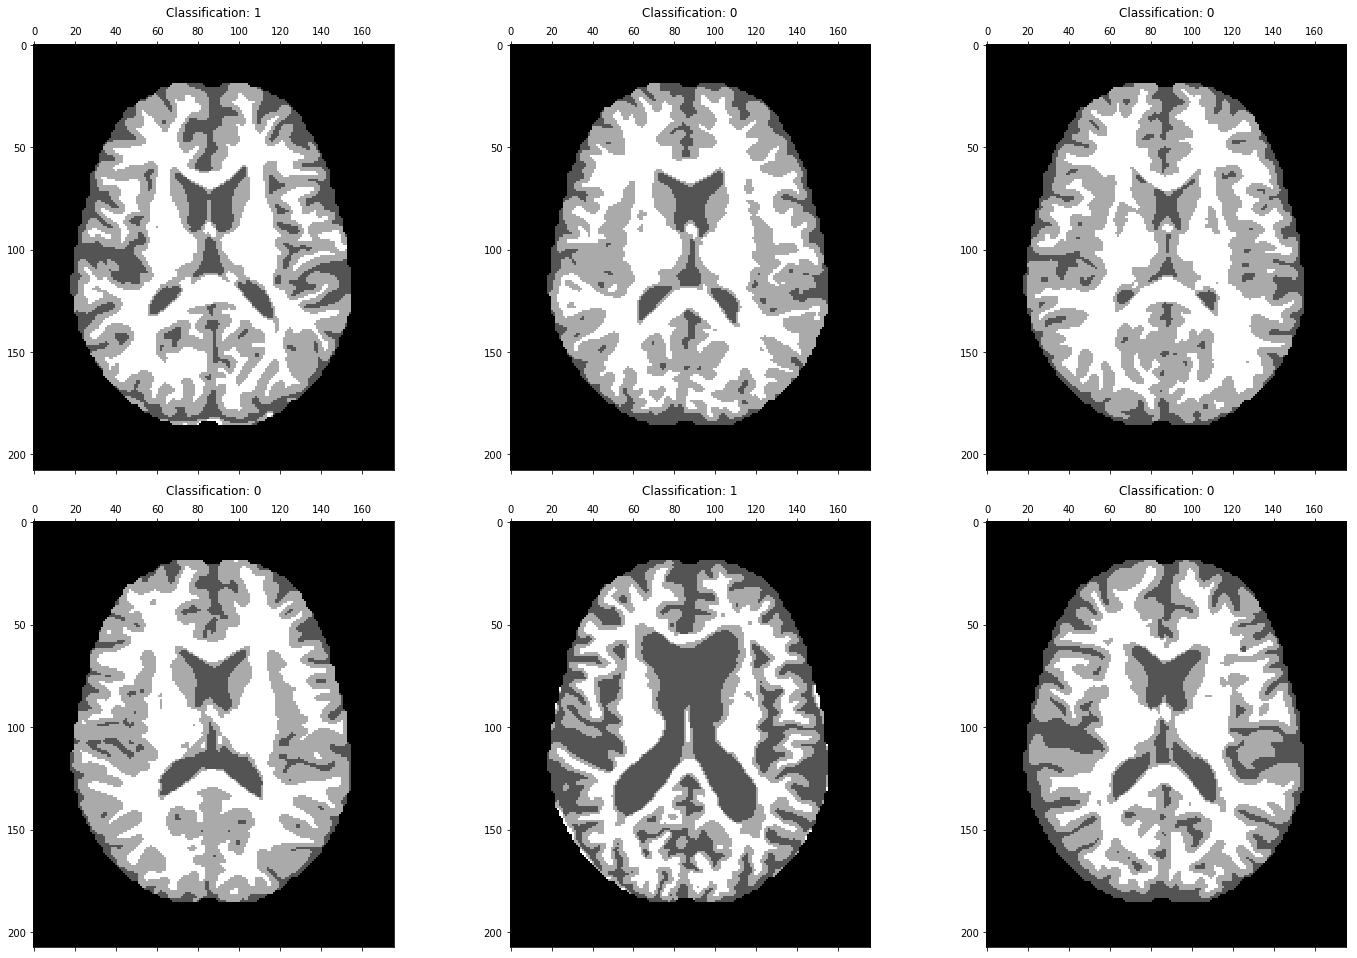

In [465]:
X = x.reshape((666,208*176))
feat_cols = ['pixel'+str(i) for i in range(X.shape[1])] # name each column a pixel number
df = pd.DataFrame(X,columns=feat_cols) # convert X to dataframe
df['label'] = y
df['label'] = df['label'].apply(lambda i: str(i)) 
rndperm = np.random.permutation(df.shape[0])

plt.gray()
fig = plt.figure(figsize=(20,20))
for i in range(0,6):
    ax = fig.add_subplot(3,3,i+1, title='Classification: ' + str(df.loc[rndperm[i],'label']) )
    ax.matshow(df.loc[rndperm[i],feat_cols].values.reshape((208,176)).astype(float))
    plt.tight_layout()
plt.show()

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning:

the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


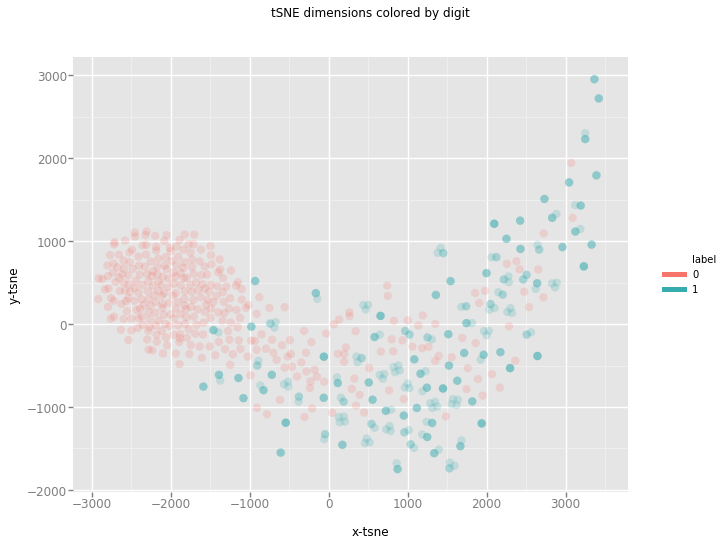

<ggplot: (7594269090)>

In [466]:
n_sne = 7000
tsne_results = tsne.fit_transform(df.loc[rndperm[:n_sne],feat_cols].values)

df_tsne = df.loc[rndperm[:n_sne],:].copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]

ggplot.ggplot(df_tsne, aes(x='x-tsne', y='y-tsne', color='label')) + geom_point(size=70,alpha=0.2) + ggtitle("tSNE dimensions colored by digit")

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



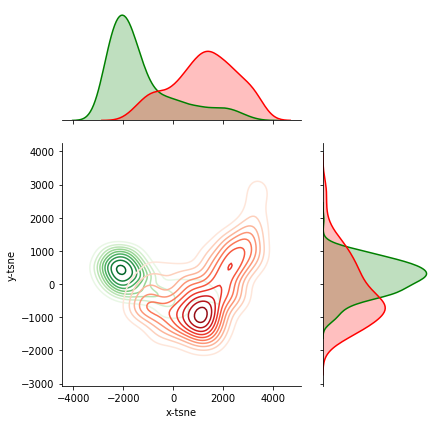

In [468]:
healthy = df_tsne.loc[df.label == "0"]
alz = df_tsne.loc[df.label == "1"]

g = sns.JointGrid(x="x-tsne", y="y-tsne", data=df_tsne, ratio = 2)
sns.kdeplot(healthy['x-tsne'], healthy['y-tsne'], cmap="Greens",
            shade=False, shade_lowest=False, ax=g.ax_joint)
sns.kdeplot(alz['x-tsne'], alz['y-tsne'], cmap="Reds",
            shade=False, shade_lowest=False, ax=g.ax_joint)
sns.kdeplot(healthy['x-tsne'], color="g", ax=g.ax_marg_x, shade = True, legend = False)
sns.kdeplot(alz['x-tsne'], color="r", ax=g.ax_marg_x, shade = True, legend = False)
sns.kdeplot(healthy['y-tsne'], color="g", ax=g.ax_marg_y, vertical=True, shade = True, legend = False)
sns.kdeplot(alz['y-tsne'], color="r", ax=g.ax_marg_y, vertical=True, shade = True, legend = False)
plt.show()

In [92]:
# --logdir=/Users/glynisttheisen/Desktop/Final

# PNCA

In [138]:
X.shape

(666, 36608)

In [139]:
m_PCA = PCA(n_components=10)
m_PCA.fit(X)
xt = m_PCA.transform(X)
xback = m_PCA.inverse_transform(xt)
assert X.shape == xback.shape
xback = xback.reshape((666,208,176))

In [95]:
def draw(input):
    plt.figure(figsize=(20,20))

    for i in range(6):
        plt.subplot(3, 3, i+1)
        plt.title('Classification: ' + str(df.loc[rndperm[i],'label']))
        plt.imshow(input[i], cmap=plt.cm.Greys)
        plt.axis('off')
    plt.show()

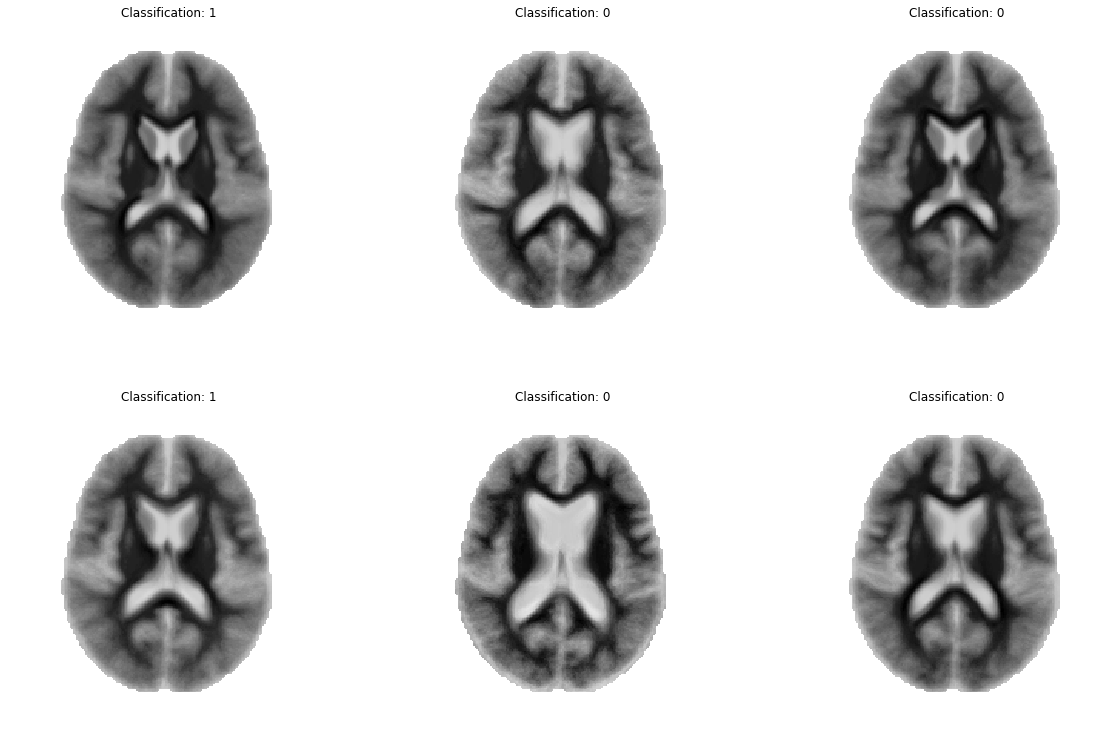

In [96]:
draw(xback)

In [140]:
X_PCA_train, X_PCA_test, y_PCA_train, y_PCA_test = train_test_split(xt,y, random_state = 42)

he = keras.initializers.he_normal(seed=42)    

model_PCA = Sequential([
Dense(100, input_shape=(10,), kernel_initializer=he),
Activation('sigmoid'),
Dense(30),
Activation('sigmoid'),
Dense(15),
Activation('sigmoid'),
Dense(1),
Activation('sigmoid'),
])
optimizer = keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model_PCA.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [150]:
model_PCA.fit(X_PCA_train,y_PCA_train,epochs=100, batch_size=50, validation_split=0.2)

Train on 399 samples, validate on 100 samples
Epoch 1/100
399/399 [==============================] - 0s 83us/step - loss: 8.5950e-04 - acc: 1.0000 - val_loss: 0.3995 - val_acc: 0.9100
Epoch 2/100
399/399 [==============================] - 0s 39us/step - loss: 8.4233e-04 - acc: 1.0000 - val_loss: 0.4004 - val_acc: 0.9100
Epoch 3/100
399/399 [==============================] - 0s 67us/step - loss: 8.2151e-04 - acc: 1.0000 - val_loss: 0.4014 - val_acc: 0.9100
Epoch 4/100
399/399 [==============================] - 0s 46us/step - loss: 8.0555e-04 - acc: 1.0000 - val_loss: 0.4036 - val_acc: 0.9100
Epoch 5/100
399/399 [==============================] - 0s 38us/step - loss: 7.8921e-04 - acc: 1.0000 - val_loss: 0.4043 - val_acc: 0.9100
Epoch 6/100
399/399 [==============================] - 0s 35us/step - loss: 7.7392e-04 - acc: 1.0000 - val_loss: 0.4065 - val_acc: 0.9100
Epoch 7/100
399/399 [==============================] - 0s 35us/step - loss: 7.6259e-04 - acc: 1.0000 - val_loss: 0.4058 - val_

399/399 [==============================] - 0s 39us/step - loss: 3.3676e-04 - acc: 1.0000 - val_loss: 0.4457 - val_acc: 0.9100
Epoch 60/100
399/399 [==============================] - 0s 45us/step - loss: 3.3317e-04 - acc: 1.0000 - val_loss: 0.4465 - val_acc: 0.9100
Epoch 61/100
399/399 [==============================] - 0s 41us/step - loss: 3.2804e-04 - acc: 1.0000 - val_loss: 0.4447 - val_acc: 0.9100
Epoch 62/100
399/399 [==============================] - 0s 45us/step - loss: 3.2592e-04 - acc: 1.0000 - val_loss: 0.4461 - val_acc: 0.9100
Epoch 63/100
399/399 [==============================] - 0s 32us/step - loss: 3.2113e-04 - acc: 1.0000 - val_loss: 0.4478 - val_acc: 0.9100
Epoch 64/100
399/399 [==============================] - 0s 58us/step - loss: 3.1631e-04 - acc: 1.0000 - val_loss: 0.4465 - val_acc: 0.9100
Epoch 65/100
399/399 [==============================] - 0s 42us/step - loss: 3.1251e-04 - acc: 1.0000 - val_loss: 0.4479 - val_acc: 0.9100
Epoch 66/100
399/399 [==================

In [151]:
PCA_accuracy, PCA_recall, PCA_precision = get_metrics(model_PCA,X_PCA_test, y_PCA_test)

167/167 [==============================] - 0s 40us/step


# Feeding in data

In [ ]:
sample = xt[1,].reshape(1,10) # take a sample from broad x set
sample.shape # shape of sample

In [ ]:
model_PCA.predict_classes(sample) # predict sample

# here

In [ ]:
dunno = ['brainmask.png', 'brainmask2.png', 'brainmask3.png','brainmask56.png']

In [ ]:
test = []
for i in dunno:
    Image = cv2.imread(f'{i}')
    Image = cv2.resize(Image, dsize=(176,208))
    Image = Image[:,:,0]
    Image = np.asarray(Image)
    Image = Image.reshape(176*208)
    Image = Image.reshape(1,-1)
    Image_t = m_PCA.transform(Image)
    test.append(Image_t)

for i in test:
    print(model_PCA.predict_classes(i))

In [ ]:
images_list = os.listdir('alz_imgs')
MacOS_file = '.DS_Store'
if MacOS_file in images_list:
    images_list.remove(MacOS_file) # remove annoying MacOS file

test = []
for i in images_list:
    Image = cv2.imread(f'alz_imgs/{i}')
    Image = cv2.resize(Image, dsize=(176,208))
    Image = Image[:,:,0]
    Image = np.asarray(Image)
    Image = Image.reshape(176*208)
    Image = Image.reshape(1,-1)
    Image_t = m_PCA.transform(Image)
    test.append(Image_t)

for i in test:
    print(model_PCA.predict_classes(i))

In [ ]:
images_list = os.listdir('healthy_imgs')
MacOS_file = '.DS_Store'
if MacOS_file in images_list:
    images_list.remove(MacOS_file) # remove annoying MacOS file

test = []
for i in images_list:
    Image = cv2.imread(f'healthy_imgs/{i}')
    Image = cv2.resize(Image, dsize=(176,208))
    Image = Image[:,:,0]
    Image = np.asarray(Image)
    Image2 = Image.reshape(208*176)
    Image2 = Image2.reshape(1,-1)
    Image_t = m_PCA.transform(Image2)
    test.append(Image_t)
    
for i in test:
    print(model_PCA.predict_classes(i))

# correct and incorrect predictions

In [ ]:
wrong_predictions = []
correct_predictions = []
for i in range(167):
    if prediction[i][0] != y_t_test[i]:
        wrong_predictions.append(i)
    else:
        correct_predictions.append(i)

In [ ]:
plt.figure(figsize=(20,20))

for x,i in enumerate(wrong_predictions):
    plt.subplot(10, 5, x+1)
    plt.title('True Classification: ' + str(df.loc[rndperm[i],'label']))
    plt.imshow(xback[i], cmap=plt.cm.Greys)
    plt.axis('off')
    plt.tight_layout()
plt.show()

In [ ]:
len(correct_predictions)

In [ ]:
correct_predictions = correct_predictions[:20]

In [ ]:
plt.figure(figsize=(20,20))

for x,i in enumerate(correct_predictions):
    plt.subplot(10, 5, x+1)
    plt.title('True Classification: ' + str(df.loc[rndperm[i],'label']))
    plt.imshow(xback[i], cmap=plt.cm.Greys)
    plt.axis('off')
    plt.tight_layout()
plt.show()

# Oasis 1 Textual Data

In [300]:
df = pd.read_csv('oasis1_cross-sectional.csv')
Subj_ID = []

for i in df['ID']:
    Subj_ID.append(get_subject(i))

df['Subject'] = pd.DataFrame(Subj_ID)

del df['ID']
del df['Hand']
del df['Delay']

In [301]:
df_demo = df[['Subject','M/F','Educ','SES','CDR','nWBV']].copy()

In [302]:
# Identify percentage of each categories composed of missing values
total = df_demo.isnull().sum().sort_values(ascending=False)
percent = df_demo.isnull().sum()/df_demo.isnull().count()*100
pd.concat([total, percent], axis=1, keys=['Total', '%'],sort=True)

,Total,%
CDR,199,46.279070
Educ,199,46.279070
M/F,0,0.000000
SES,218,50.697674
Subject,0,0.000000
nWBV,0,0.000000


In [303]:
df_demo['CDR'].fillna(0, inplace=True)
df_demo['CDR'].replace({0.5:1}, inplace=True) # replace 0.5 CDR values with 1 for Alz diagnosis
df_demo['CDR'].replace({2:1}, inplace=True) # replace 2 CDR values with 1 for Alz diagnosis

In [304]:
def replace_null(column): # fill null values with MEAN +/- STD
    mean = column.mean()
    std = column.std()
    is_null = column.isnull().sum()
    rand_VAR = np.random.randint(mean - std, mean + std, size = is_null)
    VAR_slice = column.copy()
    VAR_slice[np.isnan(VAR_slice)] = rand_VAR
    column = VAR_slice
    column = column.astype(int)
    return column

In [305]:
df_demo['Educ'] = replace_null(df_demo['Educ']) # fill missing Educ value with mean +/- SES
assert df_demo['Educ'].isnull().sum() == 0
df_demo['SES'] = replace_null(df_demo['SES']) # fill missing SES value with mean +/- SES
assert df_demo['SES'].isnull().sum() == 0

genders = {"M": 0, "F": 1}
df_demo['M/F'] = df_demo['M/F'].map(genders) # replace male = 0 and female = 1

In [306]:
temp_df = pd.DataFrame() 
for i in alz_subjects['Subject']:
    New_df = df_demo[df_demo['Subject'] == i]
    temp_df = temp_df.append(New_df, ignore_index=True) #Moving the contents of newly created dataframe to the temporary dataframe
    
total_df = df_demo.append(temp_df)
total_df.corr(method= 'pearson')

,M/F,Educ,SES,CDR,nWBV
M/F,1.000000,-0.075718,0.121101,-0.018493,0.014519
Educ,-0.075718,1.000000,-0.351571,0.086260,-0.179102
SES,0.121101,-0.351571,1.000000,0.337123,-0.386743
CDR,-0.018493,0.086260,0.337123,1.000000,-0.732078
nWBV,0.014519,-0.179102,-0.386743,-0.732078,1.000000


/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/glynismatt

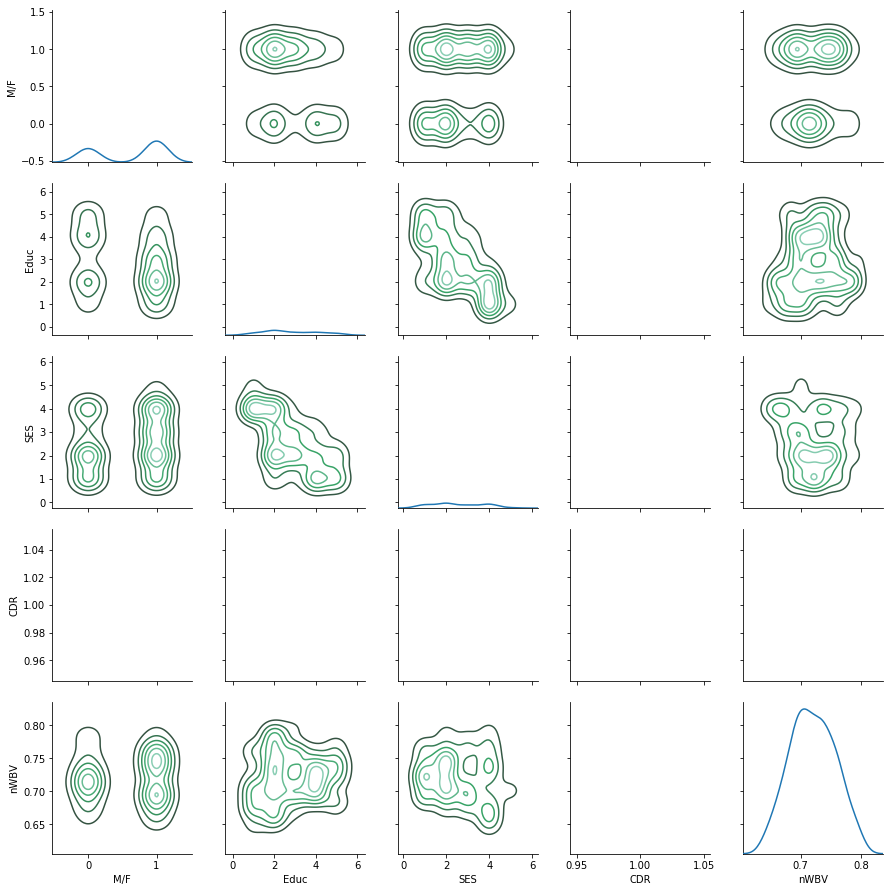

In [307]:
g = sns.PairGrid(temp_df)
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, n_levels=6);

In [308]:
total_df = total_df.drop("M/F", axis=1)
total_df.set_index('Subject',inplace=True)

X_text = total_df.drop("CDR", axis=1)
y = total_df["CDR"]

assert X_text.shape == (666, 3)
assert y.shape == (666,)


In [309]:
"""y = np.asarray(y)
y= pd.factorize(y)
y = y[0]"""

'y = np.asarray(y)\ny= pd.factorize(y)\ny = y[0]'

In [310]:
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(X_text,y, random_state = 42)

model_txt = Sequential([
    Dense(150, input_shape=(3,)),
    Activation('relu'),
    Dropout(1.0),
    Dense(75),
    Activation('relu'),
    Dense(1),
    Activation('sigmoid'),
])

optimizer = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model_txt.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [311]:
model_txt.fit(X_text_train,y_text_train,epochs=100, batch_size=25)

Epoch 1/100
499/499 [==============================] - 1s 1ms/step - loss: 0.6771 - acc: 0.5631
Epoch 2/100
499/499 [==============================] - 0s 79us/step - loss: 0.6704 - acc: 0.5631
Epoch 3/100
499/499 [==============================] - 0s 64us/step - loss: 0.6658 - acc: 0.6112
Epoch 4/100
499/499 [==============================] - 0s 79us/step - loss: 0.6624 - acc: 0.6333
Epoch 5/100
499/499 [==============================] - 0s 54us/step - loss: 0.6593 - acc: 0.6573
Epoch 6/100
499/499 [==============================] - 0s 70us/step - loss: 0.6569 - acc: 0.6553
Epoch 7/100
499/499 [==============================] - 0s 68us/step - loss: 0.6543 - acc: 0.6713
Epoch 8/100
499/499 [==============================] - 0s 83us/step - loss: 0.6511 - acc: 0.6914
Epoch 9/100
499/499 [==============================] - 0s 93us/step - loss: 0.6485 - acc: 0.6994
Epoch 10/100
499/499 [==============================] - 0s 70us/step - loss: 0.6457 - acc: 0.6713
Epoch 11/100
499/499 [========

499/499 [==============================] - 0s 65us/step - loss: 0.5467 - acc: 0.7074
Epoch 85/100
499/499 [==============================] - 0s 65us/step - loss: 0.5466 - acc: 0.6934
Epoch 86/100
499/499 [==============================] - 0s 75us/step - loss: 0.5467 - acc: 0.7114
Epoch 87/100
499/499 [==============================] - 0s 57us/step - loss: 0.5446 - acc: 0.7094
Epoch 88/100
499/499 [==============================] - 0s 83us/step - loss: 0.5452 - acc: 0.6934
Epoch 89/100
499/499 [==============================] - 0s 76us/step - loss: 0.5445 - acc: 0.7094
Epoch 90/100
499/499 [==============================] - 0s 79us/step - loss: 0.5441 - acc: 0.7094
Epoch 91/100
499/499 [==============================] - 0s 72us/step - loss: 0.5437 - acc: 0.7094
Epoch 92/100
499/499 [==============================] - 0s 78us/step - loss: 0.5433 - acc: 0.7094
Epoch 93/100
499/499 [==============================] - 0s 80us/step - loss: 0.5429 - acc: 0.7094
Epoch 94/100
499/499 [===========

In [315]:
txt_accuracy, txt_recall, txt_precision = get_metrics(model_txt,X_text_test, y_text_test)

167/167 [==============================] - 0s 65us/step


# Random Forest

In [326]:
RanFor = RandomForestClassifier(max_depth = 2, n_estimators = 15)
RanFor.fit(X_text_train,y_text_train)
print ("Training score: " + str(round(RanFor.score(X_text_train,y_text_train)*100,2)) + '%')
print ("Test score: " + str(round(RanFor.score(X_text_test,y_text_test)*100,2)) + '%')

Training score: 87.17%
Test score: 89.22%


In [327]:
random_trees, random_depths =  random.sample(range(1,20),10), random.sample(range(1,50),25)

In [328]:
grid = GridSearchCV(RanFor, 
        param_grid={'n_estimators': random_trees, 'max_depth': random_depths},
        scoring='accuracy', 
        n_jobs=1,
        cv=5
        )

grid.fit(X_text_train,y_text_train)
print("Best score: " + str(round(grid.best_score_*100,2)) + '%', str(grid.best_params_))

Best score: 90.18% {'max_depth': 36, 'n_estimators': 12}


In [329]:
final_model = grid.best_estimator_
final_model.fit(X_text_train,y_text_train)

print ("Training score: " + str(final_model.score(X_text_train,y_text_train)))
print ("Test score: " + str(final_model.score(X_text_test,y_text_test)))

Training score: 0.9799599198396793
Test score: 0.9161676646706587


In [330]:
RF_txt_accuracy = round(final_model.score(X_text_test,y_text_test)*100,2)
txt_pred = final_model.predict(X_text_test)
RF_txt_recall = round((recall_score(y_text_test, txt_pred))*100, 2)
RF_txt_precision = round(precision_score(y_text_test, txt_pred)*100, 2)

# Oasis 1 FS

In [358]:
free = pd.read_csv('oasis1_FS.csv')
free.set_index('Subject', inplace=True)
subjects_x = subjects.set_index('Subject')

del free['FS_ASEGREGIONANALYSIS ID']
del free['MR ID']

subjects_x = subjects_x.head(423)
subjects_x = subjects_x.sort_index(ascending = True)

merge = free.merge(subjects_x, how='inner',left_index=True, right_index=True)

In [363]:
norm_to_ICV = lambda x : x / merge['ICV']

In [364]:
del merge['BrainMaskVol']
del merge['BrainSegNVox']
merge['BrainMaskNVox'] = norm_to_ICV(merge['BrainMaskNVox'])
merge['BrainSegVol'] = norm_to_ICV(merge['BrainSegVol'])

In [365]:
merge.corr()

,BrainMaskNVox,BrainSegVol,ICV,Diagnosis
BrainMaskNVox,1.000000,0.854474,-0.381174,-0.461668
BrainSegVol,0.854474,1.000000,-0.161257,-0.588211
ICV,-0.381174,-0.161257,1.000000,0.002552
Diagnosis,-0.461668,-0.588211,0.002552,1.000000


In [366]:
temp_df = pd.DataFrame() 
for i in alz_subjects['Subject']:
    New_df = df_demo[df_demo['Subject'] == i]
    temp_df = temp_df.append(New_df, ignore_index=True) #Moving the contents of newly created dataframe to the temporary dataframe
    
total_df = df_demo.append(temp_df)

total_df.set_index('Subject',inplace=True)

In [367]:
total_df = total_df.head(423)

In [368]:
merge_2 = merge.merge(total_df, how='inner',left_index=True, right_index=True)

In [369]:
merge_2.corr()

,BrainMaskNVox,BrainSegVol,ICV,Diagnosis,M/F,Educ,SES,CDR,nWBV
BrainMaskNVox,1.000000,0.858367,-0.391878,-0.447697,0.204238,-0.182965,-0.215170,-0.447697,0.620945
BrainSegVol,0.858367,1.000000,-0.172769,-0.581303,0.108956,-0.256577,-0.307451,-0.581303,0.861510
ICV,-0.391878,-0.172769,1.000000,-0.021834,-0.519074,-0.009111,-0.236284,-0.021834,0.040115
Diagnosis,-0.447697,-0.581303,-0.021834,1.000000,-0.032847,0.079117,0.340303,1.000000,-0.649548
M/F,0.204238,0.108956,-0.519074,-0.032847,1.000000,0.006659,0.112774,-0.032847,0.040699
Educ,-0.182965,-0.256577,-0.009111,0.079117,0.006659,1.000000,-0.161668,0.079117,-0.276657
SES,-0.215170,-0.307451,-0.236284,0.340303,0.112774,-0.161668,1.000000,0.340303,-0.416069
CDR,-0.447697,-0.581303,-0.021834,1.000000,-0.032847,0.079117,0.340303,1.000000,-0.649548
nWBV,0.620945,0.861510,0.040115,-0.649548,0.040699,-0.276657,-0.416069,-0.649548,1.000000


In [349]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)


/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/ipywidgets/widgets/widget.py:281: DeprecationWarning:

Widget registration using a string name has been deprecated. Widget registration now uses a plain `@register` decorator.



/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



Text(0.5, 1.0, 'Male')

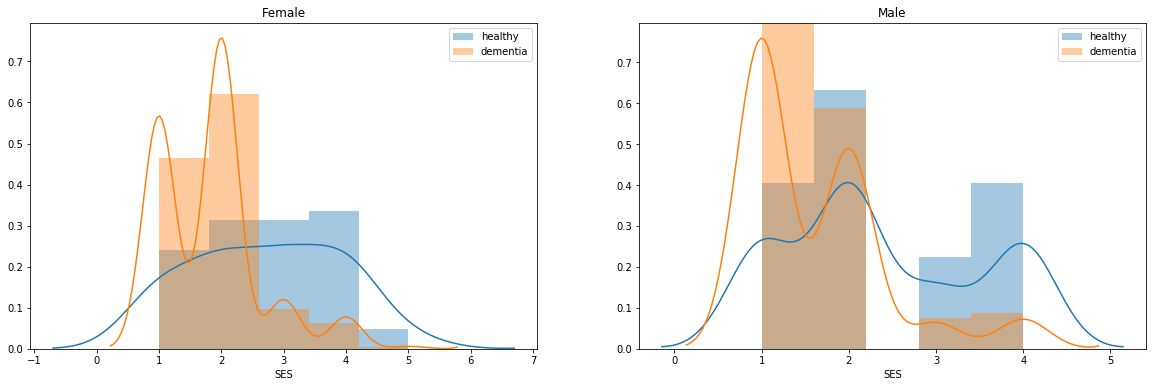

In [350]:
survived = 'healthy'
not_survived = 'dementia'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(20, 6))
women = merge_2[merge_2['M/F']== 1]
men = merge_2[merge_2['M/F']== 0]
ax = sns.distplot(women[women['CDR']==1.0].SES, bins=5, label = survived, ax = axes[0], kde =True)
ax = sns.distplot(women[women['CDR']==0.0].SES, bins=5, label = not_survived, ax = axes[0], kde =True)
ax.legend()
ax.set_title('Female')
ax = sns.distplot(men[men['CDR']==1].SES, bins=5, label = survived, ax = axes[1], kde = True)
ax = sns.distplot(men[men['CDR']==0].SES, bins=5, label = not_survived, ax = axes[1], kde = True)
ax.legend()
ax.set_title('Male')

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



Text(0.5, 1.0, 'Educ and CDR')

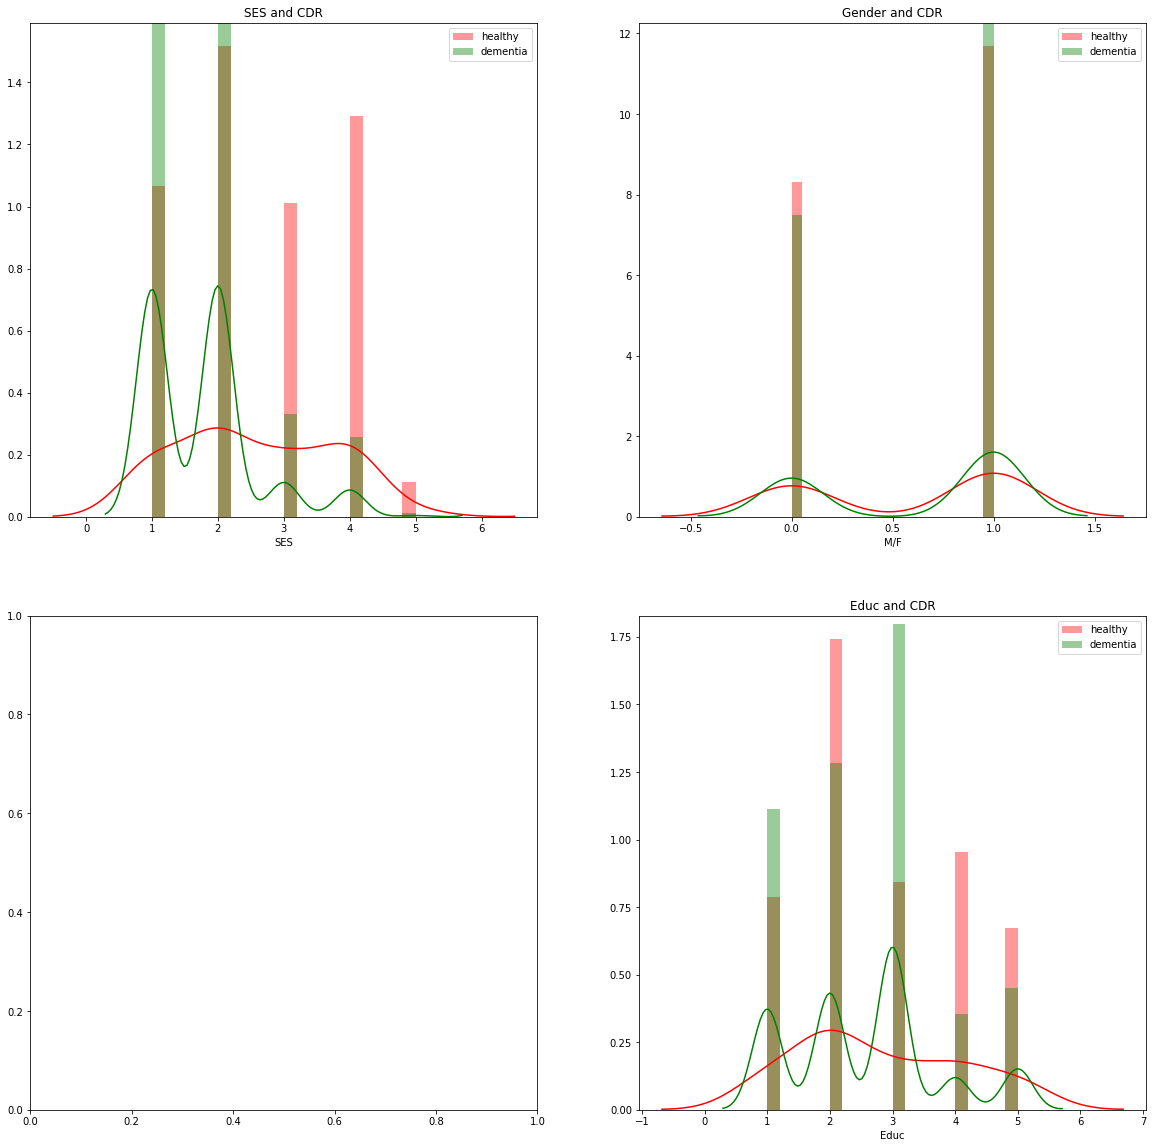

In [351]:
healthy = 'healthy'
dementia = 'dementia'
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(20, 20))
ax = sns.distplot(merge_2[merge_2['CDR']==1.0].SES, bins=20, label = healthy, ax = axes[0][0], kde =True, color='red')
ax = sns.distplot(merge_2[merge_2['CDR']==0.0].SES, bins=20, label = dementia, ax = axes[0][0], kde =True, color ='green')
ax.legend()
ax.set_title('SES and CDR')

ax = sns.distplot(merge_2[merge_2['CDR']==1.0]['M/F'], bins=20, label = healthy, ax = axes[0][1], kde =True,color='red')
ax = sns.distplot(merge_2[merge_2['CDR']==0.0]['M/F'], bins=20, label = dementia, ax = axes[0][1], kde =True,color='green')
ax.legend()
ax.set_title('Gender and CDR')


ax = sns.distplot(merge_2[merge_2['CDR']==1.0]['Educ'], bins=20, label = healthy, ax = axes[1][1], kde =True,color='red')
ax = sns.distplot(merge_2[merge_2['CDR']==0.0]['Educ'], bins=20, label = dementia, ax = axes[1][1], kde =True,color='green')
ax.legend()
ax.set_title('Educ and CDR')

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



Text(0.5, 1.0, 'CDR and BrainSegVol')

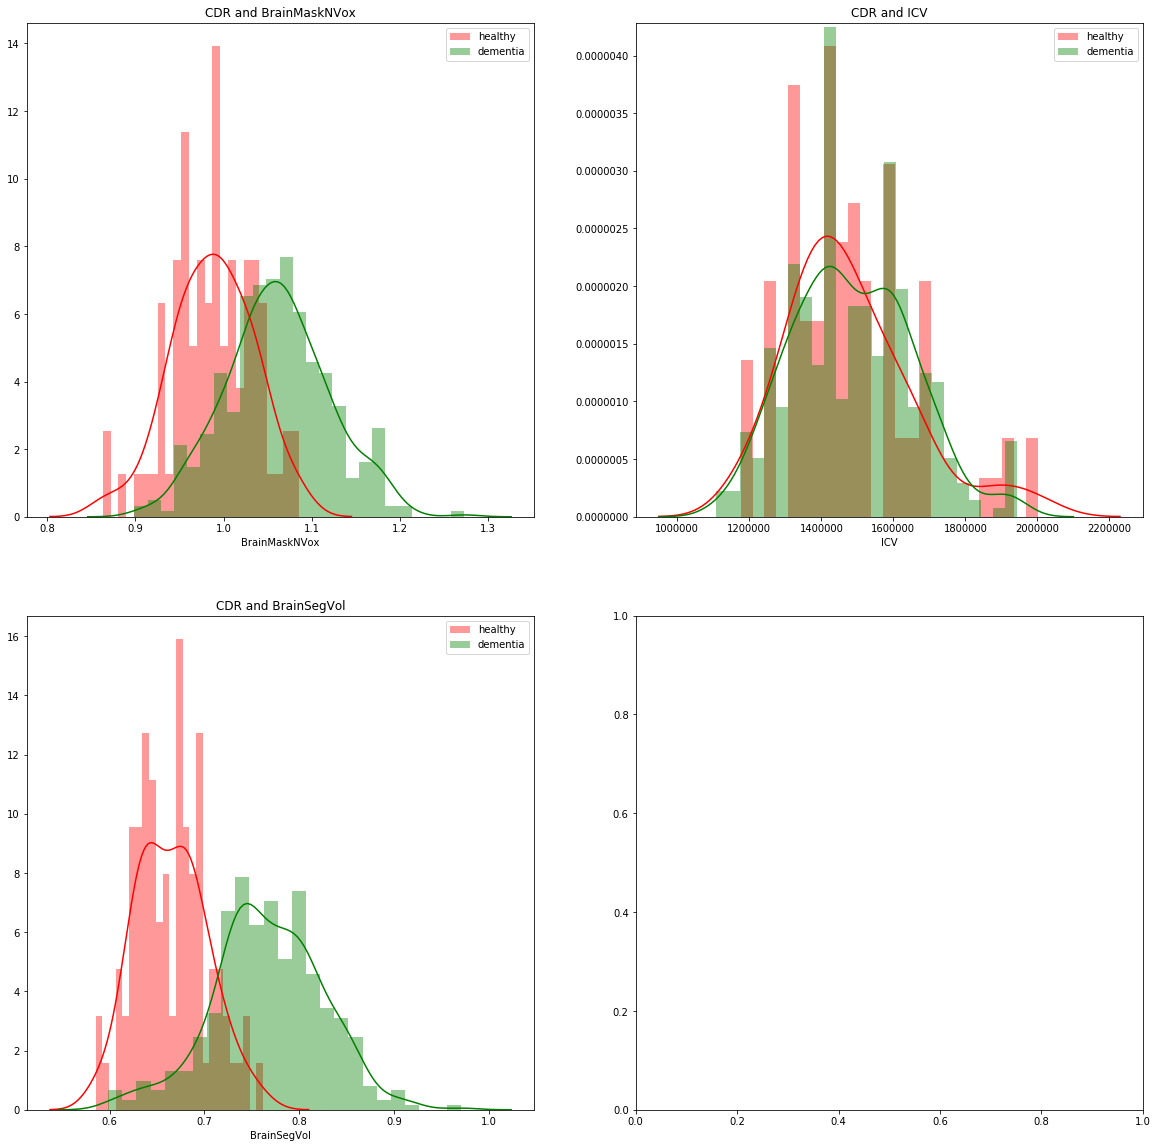

In [352]:
healthy = 'healthy'
dementia = 'dementia'
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(20, 20))
ax = sns.distplot(merge_2[merge_2['CDR']==1.0].BrainMaskNVox, bins=25, label = healthy, ax = axes[0][0], kde =True, color='red')
ax = sns.distplot(merge_2[merge_2['CDR']==0.0].BrainMaskNVox, bins=25, label = dementia, ax = axes[0][0], kde =True, color ='green')
ax.legend()
ax.set_title('CDR and BrainMaskNVox')

ax = sns.distplot(merge_2[merge_2['CDR']==1.0].ICV, bins=25, label = healthy, ax = axes[0][1], kde =True,color='red')
ax = sns.distplot(merge_2[merge_2['CDR']==0.0].ICV, bins=25, label = dementia, ax = axes[0][1], kde =True,color='green')
ax.legend()
ax.set_title('CDR and ICV')

ax = sns.distplot(merge_2[merge_2['CDR']==1.0].BrainSegVol, bins=25, label = healthy, ax = axes[1][0], kde =True,color='red')
ax = sns.distplot(merge_2[merge_2['CDR']==0.0].BrainSegVol, bins=25, label = dementia, ax = axes[1][0], kde =True,color='green')
ax.legend()
ax.set_title('CDR and BrainSegVol')

In [370]:
merge_2.head(4)

,BrainMaskNVox,BrainSegVol,ICV,Diagnosis,M/F,Educ,SES,CDR,nWBV
Subject,,,,,,,,,
OAS1_0002,1.069785,0.762842,1151269.287,0,1,4,1,0.0,0.810
OAS1_0003,0.994005,0.677106,1403415.054,1,1,4,3,1.0,0.708
OAS1_0004,1.008911,0.729594,1593284.910,0,0,1,2,0.0,0.803
OAS1_0005,1.036834,0.789169,1733779.281,0,0,1,1,0.0,0.848


In [371]:
del merge_2['CDR']
del merge_2['ICV']

In [374]:
corr = merge_2.corr()

In [397]:
corr

,BrainMaskNVox,BrainSegVol,Diagnosis,M/F,Educ,SES,nWBV
BrainMaskNVox,1.000000,0.858367,-0.447697,0.204238,-0.182965,-0.215170,0.620945
BrainSegVol,0.858367,1.000000,-0.581303,0.108956,-0.256577,-0.307451,0.861510
Diagnosis,-0.447697,-0.581303,1.000000,-0.032847,0.079117,0.340303,-0.649548
M/F,0.204238,0.108956,-0.032847,1.000000,0.006659,0.112774,0.040699
Educ,-0.182965,-0.256577,0.079117,0.006659,1.000000,-0.161668,-0.276657
SES,-0.215170,-0.307451,0.340303,0.112774,-0.161668,1.000000,-0.416069
nWBV,0.620945,0.861510,-0.649548,0.040699,-0.276657,-0.416069,1.000000


In [456]:
healthy = merge_2[merge_2['Diagnosis'] ==0]
alz = merge_2[merge_2['Diagnosis'] ==1]
healthy.describe()

,BrainMaskNVox,BrainSegVol,Diagnosis,M/F,Educ,SES,nWBV
count,409.000000,409.000000,409.0,409.000000,409.000000,409.000000,409.000000
mean,1.061428,0.767137,0.0,0.625917,2.550122,1.738386,0.819218
std,0.058718,0.057977,0.0,0.484478,1.174924,0.815005,0.046090
min,0.898880,0.598557,0.0,0.000000,1.000000,1.000000,0.645000
25%,1.024003,0.731835,0.0,0.000000,2.000000,1.000000,0.800000
50%,1.061511,0.768665,0.0,1.000000,3.000000,2.000000,0.834000
75%,1.098918,0.806031,0.0,1.000000,3.000000,2.000000,0.850000
max,1.273024,0.971192,0.0,1.000000,5.000000,5.000000,0.893000


In [457]:
alz.describe()

,BrainMaskNVox,BrainSegVol,Diagnosis,M/F,Educ,SES,nWBV
count,89.000000,89.000000,89.0,89.00000,89.000000,89.000000,89.000000
mean,0.987466,0.665045,1.0,0.58427,2.797753,2.573034,0.720247
std,0.046273,0.037125,0.0,0.49564,1.298424,1.156873,0.036040
min,0.862992,0.585271,1.0,0.00000,1.000000,1.000000,0.644000
25%,0.954419,0.637336,1.0,0.00000,2.000000,2.000000,0.694000
50%,0.989696,0.664340,1.0,1.00000,2.000000,2.000000,0.719000
75%,1.023574,0.688246,1.0,1.00000,4.000000,4.000000,0.745000
max,1.084934,0.761927,1.0,1.00000,5.000000,5.000000,0.797000


In [375]:
columns = corr.columns.values

In [444]:
list_n = [item*150 for item in z] 

In [445]:
abs_list = lambda x :abs(x) # normalize x values

In [446]:
for x, i in enumerate(list_n):
    list_n[x] = abs(i)

In [452]:
import plotly.plotly as py
import plotly.graph_objs as go

z = [-0.447697,-0.581303,1, -0.032847,0.079117,0.340303,-0.649548]

trace0 = go.Scatter(
    x=[-3.5,-2.5, 0, -4.5, 2.25, 1.25, -1.5],
    y=[-0.447697,-0.581303,1, -0.032847,0.079117,0.340303,-0.649548],
    text=columns,
    hoverinfo = 'y',
    textposition=['bottom center','top center','middle center','bottom center','bottom center','middle center','middle center'],
    mode='markers + text',
    marker=dict(
        color =[300,325,375,275,325,350,350],
        opacity=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
        size=list_n,
        showscale=False

    )
)

layout = go.Layout(
    xaxis=dict(
        autorange=True,
        showgrid=False,
        zeroline=False,
        showline=False,
        ticks='',
        showticklabels=False
    ),
    yaxis=dict(
        range=[-25,25],
        showgrid=False,
        zeroline=False,
        showline=False,
        ticks='',
        showticklabels=False
    )
)

data = [trace0]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bubblechart-color')



In [377]:
merge_2.head()

,BrainMaskNVox,BrainSegVol,Diagnosis,M/F,Educ,SES,nWBV
Subject,,,,,,,
OAS1_0002,1.069785,0.762842,0,1,4,1,0.810
OAS1_0003,0.994005,0.677106,1,1,4,3,0.708
OAS1_0004,1.008911,0.729594,0,0,1,2,0.803
OAS1_0005,1.036834,0.789169,0,0,1,1,0.848
OAS1_0007,1.027285,0.754648,0,0,3,1,0.830


In [379]:
X_text = merge_2.drop("Diagnosis", axis=1)
y = merge_2["Diagnosis"]
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(X_text,y, random_state = 42)

In [380]:
RanFor = RandomForestClassifier(max_depth = 2, n_estimators = 15)
RanFor.fit(X_text_train,y_text_train)
print ("Training score: " + str(round(RanFor.score(X_text_train,y_text_train)*100,2)) + '%')
print ("Test score: " + str(round(RanFor.score(X_text_test,y_text_test)*100,2)) + '%')

Training score: 89.54%
Test score: 87.2%


In [394]:
random_trees, random_depths =  random.sample(range(1,30),10), random.sample(range(1,50),25)

In [395]:
grid = GridSearchCV(RanFor, 
        param_grid={'n_estimators': random_trees, 'max_depth': random_depths},
        scoring='accuracy', 
        n_jobs=1,
        cv=5
        )

grid.fit(X_text_train,y_text_train)
print("Best score: " + str(round(grid.best_score_*100,2)) + '%', str(grid.best_params_))

Best score: 89.81% {'max_depth': 4, 'n_estimators': 11}


In [396]:
final_model = grid.best_estimator_
final_model.fit(X_text_train,y_text_train)

print ("Training score: " + str(final_model.score(X_text_train,y_text_train)))
print ("Test score: " + str(final_model.score(X_text_test,y_text_test)))

Training score: 0.9329758713136729
Test score: 0.856


In [386]:
RF_txt_vol_accuracy = round(final_model.score(X_text_test,y_text_test)*100,2)
txt_vol_pred = final_model.predict(X_text_test)
RF_txt_vol_recall = round((recall_score(y_text_test, txt_vol_pred))*100, 2)
RF_txt_vol_precision = round(precision_score(y_text_test, txt_vol_pred)*100, 2)

## Results

In [393]:
 results = pd.DataFrame({
    'Data Processing': ['Model','T-SNE','PCA','txt_NN','RF_text','RF_text_vol'],
    'Accuracy': [model_accuracy,t_sne_accuracy,PCA_accuracy, txt_accuracy, RF_txt_accuracy, RF_txt_vol_accuracy],
    'Precision': [model_precision,tsne_precision,PCA_precision, txt_precision, RF_txt_precision, RF_txt_vol_precision],
    'Recall': [model_recall,tsne_recall,PCA_recall, txt_recall, RF_txt_recall, RF_txt_vol_recall]
 })
result_df = results.sort_values(by='Accuracy', ascending=False)
result_df = result_df.set_index('Data Processing')
result_df

,Accuracy,Precision,Recall
Data Processing,,,
RF_text,91.62,88.04,96.43
PCA,91.02,87.91,95.24
T-SNE,89.22,85.87,94.05
Model,88.02,85.56,91.67
RF_text_vol,85.60,64.29,69.23
txt_NN,73.05,72.41,75.00
